In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100, use_bias=False,input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(50, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(10, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5000      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0

943/943 [==============================] - 2s 2ms/step - loss: 0.3845 - accuracy: 0.8164 - val_loss: 0.3441 - val_accuracy: 0.8442
Epoch 44/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3844 - accuracy: 0.8146 - val_loss: 0.3444 - val_accuracy: 0.8448
Epoch 45/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3849 - accuracy: 0.8165 - val_loss: 0.3440 - val_accuracy: 0.8444
Epoch 46/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3855 - accuracy: 0.8150 - val_loss: 0.3440 - val_accuracy: 0.8450
Epoch 47/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3856 - accuracy: 0.8121 - val_loss: 0.3441 - val_accuracy: 0.8446
Epoch 48/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3857 - accuracy: 0.8139 - val_loss: 0.3439 - val_accuracy: 0.8445
Epoch 49/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3843 - accuracy: 0.8182 - val_loss: 0.3442 - val_accuracy: 0.8448
Epoch

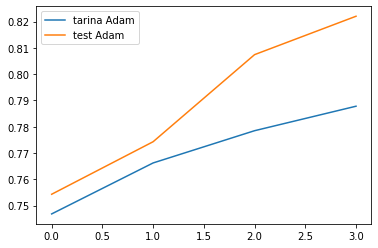

In [6]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do poniższego modelu dodaj
 
```python
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

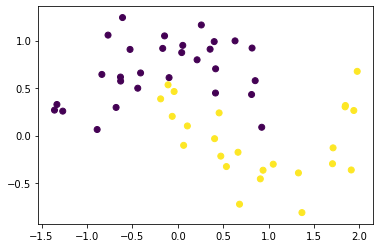

In [7]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [8]:
from tensorflow.keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_9 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_10 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 76ms/step - loss: 0.7453 - accuracy: 0.4906 - val_loss: 0.6782 - val_accuracy: 0.5532
Epoch 2/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.7282 - accuracy: 0.5472 - val_

Epoch 110/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0568 - accuracy: 0.9623 - val_loss: 0.2340 - val_accuracy: 0.9149
Epoch 111/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0547 - accuracy: 0.9623 - val_loss: 0.2095 - val_accuracy: 0.9149
Epoch 112/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0487 - accuracy: 1.0000 - val_loss: 0.1878 - val_accuracy: 0.9149
Epoch 113/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.0477 - accuracy: 1.0000 - val_loss: 0.1746 - val_accuracy: 0.8936
Epoch 114/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0498 - accuracy: 1.0000 - val_loss: 0.1708 - val_accuracy: 0.8936
Epoch 115/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0508 - accuracy: 1.0000 - val_loss: 0.1784 - val_accuracy: 0.8936
Epoch 116/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0462 - accuracy: 1.0000 - val_loss: 0.1972 - val_accuracy: 0.9149

2/2 [==============================] - 0s 17ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.2040 - val_accuracy: 0.9149
Epoch 225/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.2037 - val_accuracy: 0.9149
Epoch 226/1000
2/2 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 1.00 - 0s 16ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.2061 - val_accuracy: 0.8936
Epoch 227/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.2073 - val_accuracy: 0.8936
Epoch 228/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.2095 - val_accuracy: 0.8936
Epoch 229/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.2096 - val_accuracy: 0.8936
Epoch 230/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.

2/2 [==============================] - 0s 16ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.2240 - val_accuracy: 0.9149
Epoch 282/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2240 - val_accuracy: 0.9149
Epoch 283/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2238 - val_accuracy: 0.9149
Epoch 284/1000
2/2 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 1.00 - 0s 17ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2239 - val_accuracy: 0.9149
Epoch 285/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.2240 - val_accuracy: 0.9149
Epoch 286/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.2246 - val_accuracy: 0.9149
Epoch 287/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.

2/2 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2476 - val_accuracy: 0.9149
Epoch 339/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2485 - val_accuracy: 0.9149
Epoch 340/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2486 - val_accuracy: 0.9149
Epoch 341/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2489 - val_accuracy: 0.9149
Epoch 342/1000
2/2 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 1.00 - 0s 18ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2486 - val_accuracy: 0.9149
Epoch 343/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2484 - val_accuracy: 0.9149
Epoch 344/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.

2/2 [==============================] - 0s 15ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2682 - val_accuracy: 0.9149
Epoch 396/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2687 - val_accuracy: 0.9149
Epoch 397/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2694 - val_accuracy: 0.9149
Epoch 398/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2702 - val_accuracy: 0.9149
Epoch 399/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2715 - val_accuracy: 0.9149
Epoch 400/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2722 - val_accuracy: 0.9149
Epoch 401/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2730 - val_accuracy: 0.9149
Epoch 402/1000

2/2 [==============================] - 0s 15ms/step - loss: 9.0942e-04 - accuracy: 1.0000 - val_loss: 0.3206 - val_accuracy: 0.8936
Epoch 509/1000
2/2 [==============================] - 0s 15ms/step - loss: 8.3251e-04 - accuracy: 1.0000 - val_loss: 0.3210 - val_accuracy: 0.8936
Epoch 510/1000
2/2 [==============================] - 0s 14ms/step - loss: 8.2599e-04 - accuracy: 1.0000 - val_loss: 0.3212 - val_accuracy: 0.8936
Epoch 511/1000
2/2 [==============================] - 0s 20ms/step - loss: 8.5827e-04 - accuracy: 1.0000 - val_loss: 0.3218 - val_accuracy: 0.8936
Epoch 512/1000
2/2 [==============================] - 0s 17ms/step - loss: 8.3105e-04 - accuracy: 1.0000 - val_loss: 0.3224 - val_accuracy: 0.8936
Epoch 513/1000
2/2 [==============================] - 0s 15ms/step - loss: 8.6812e-04 - accuracy: 1.0000 - val_loss: 0.3234 - val_accuracy: 0.8936
Epoch 514/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.00 - 0s 19ms/step - loss: 8.1457e-04 - acc

Epoch 619/1000
2/2 [==============================] - 0s 21ms/step - loss: 4.9741e-04 - accuracy: 1.0000 - val_loss: 0.3644 - val_accuracy: 0.8936
Epoch 620/1000
2/2 [==============================] - 0s 20ms/step - loss: 4.9596e-04 - accuracy: 1.0000 - val_loss: 0.3645 - val_accuracy: 0.8936
Epoch 621/1000
2/2 [==============================] - 0s 19ms/step - loss: 5.1989e-04 - accuracy: 1.0000 - val_loss: 0.3646 - val_accuracy: 0.8936
Epoch 622/1000
2/2 [==============================] - 0s 20ms/step - loss: 5.0388e-04 - accuracy: 1.0000 - val_loss: 0.3648 - val_accuracy: 0.8936
Epoch 623/1000
2/2 [==============================] - 0s 15ms/step - loss: 5.1960e-04 - accuracy: 1.0000 - val_loss: 0.3656 - val_accuracy: 0.8936
Epoch 624/1000
2/2 [==============================] - 0s 13ms/step - loss: 4.8573e-04 - accuracy: 1.0000 - val_loss: 0.3664 - val_accuracy: 0.8936
Epoch 625/1000
2/2 [==============================] - 0s 16ms/step - loss: 4.8576e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 730/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.2915e-04 - accuracy: 1.0000 - val_loss: 0.3949 - val_accuracy: 0.8936
Epoch 731/1000
2/2 [==============================] - 0s 17ms/step - loss: 3.2901e-04 - accuracy: 1.0000 - val_loss: 0.3952 - val_accuracy: 0.8936
Epoch 732/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.2077e-04 - accuracy: 1.0000 - val_loss: 0.3959 - val_accuracy: 0.8936
Epoch 733/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.3913e-04 - accuracy: 1.0000 - val_loss: 0.3967 - val_accuracy: 0.8936
Epoch 734/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.2540e-04 - accuracy: 1.0000 - val_loss: 0.3972 - val_accuracy: 0.8936
Epoch 735/1000
2/2 [==============================] - 0s 15ms/step - loss: 3.2527e-04 - accuracy: 1.0000 - val_loss: 0.3977 - val_accuracy: 0.8936
Epoch 736/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.2509e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 786/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.6780e-04 - accuracy: 1.0000 - val_loss: 0.4105 - val_accuracy: 0.8936
Epoch 787/1000
2/2 [==============================] - 0s 18ms/step - loss: 2.6743e-04 - accuracy: 1.0000 - val_loss: 0.4109 - val_accuracy: 0.8936
Epoch 788/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.7100e-04 - accuracy: 1.0000 - val_loss: 0.4110 - val_accuracy: 0.8936
Epoch 789/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.6565e-04 - accuracy: 1.0000 - val_loss: 0.4113 - val_accuracy: 0.8936
Epoch 790/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.6515e-04 - accuracy: 1.0000 - val_loss: 0.4117 - val_accuracy: 0.8936
Epoch 791/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.6391e-04 - accuracy: 1.0000 - val_loss: 0.4120 - val_accuracy: 0.8936
Epoch 792/1000
2/2 [==============================] - 0s 23ms/step - loss: 2.6846e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 842/1000
2/2 [==============================] - 0s 18ms/step - loss: 2.2862e-04 - accuracy: 1.0000 - val_loss: 0.4241 - val_accuracy: 0.8936
Epoch 843/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.2657e-04 - accuracy: 1.0000 - val_loss: 0.4245 - val_accuracy: 0.8936
Epoch 844/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.2936e-04 - accuracy: 1.0000 - val_loss: 0.4247 - val_accuracy: 0.8936
Epoch 845/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.2588e-04 - accuracy: 1.0000 - val_loss: 0.4249 - val_accuracy: 0.8936
Epoch 846/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.2553e-04 - accuracy: 1.0000 - val_loss: 0.4250 - val_accuracy: 0.8936
Epoch 847/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.2422e-04 - accuracy: 1.0000 - val_loss: 0.4250 - val_accuracy: 0.8936
Epoch 848/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.2413e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 898/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.9347e-04 - accuracy: 1.0000 - val_loss: 0.4337 - val_accuracy: 0.8936
Epoch 899/1000
2/2 [==============================] - 0s 21ms/step - loss: 1.9745e-04 - accuracy: 1.0000 - val_loss: 0.4343 - val_accuracy: 0.8936
Epoch 900/1000
2/2 [==============================] - 0s 19ms/step - loss: 1.9404e-04 - accuracy: 1.0000 - val_loss: 0.4347 - val_accuracy: 0.8936
Epoch 901/1000
2/2 [==============================] - 0s 21ms/step - loss: 1.9328e-04 - accuracy: 1.0000 - val_loss: 0.4348 - val_accuracy: 0.8936
Epoch 902/1000
2/2 [==============================] - 0s 21ms/step - loss: 1.9341e-04 - accuracy: 1.0000 - val_loss: 0.4352 - val_accuracy: 0.8936
Epoch 903/1000
2/2 [==============================] - 0s 22ms/step - loss: 1.8828e-04 - accuracy: 1.0000 - val_loss: 0.4355 - val_accuracy: 0.8936
Epoch 904/1000
2/2 [==============================] - 0s 23ms/step - loss: 1.9022e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 954/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.6298e-04 - accuracy: 1.0000 - val_loss: 0.4471 - val_accuracy: 0.8936
Epoch 955/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.6174e-04 - accuracy: 1.0000 - val_loss: 0.4471 - val_accuracy: 0.8936
Epoch 956/1000
2/2 [==============================] - 0s 19ms/step - loss: 1.6264e-04 - accuracy: 1.0000 - val_loss: 0.4470 - val_accuracy: 0.8936
Epoch 957/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.6807e-04 - accuracy: 1.0000 - val_loss: 0.4471 - val_accuracy: 0.8936
Epoch 958/1000
2/2 [==============================] - 0s 14ms/step - loss: 1.6379e-04 - accuracy: 1.0000 - val_loss: 0.4474 - val_accuracy: 0.8936
Epoch 959/1000
2/2 [==============================] - 0s 18ms/step - loss: 1.6230e-04 - accuracy: 1.0000 - val_loss: 0.4478 - val_accuracy: 0.8936
Epoch 960/1000
2/2 [==============================] - ETA: 0s - loss: 1.3073e-04 - accuracy: 1.00 - 0s 17ms/step - los

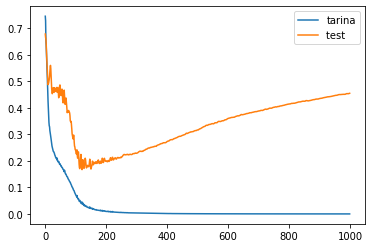

In [13]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


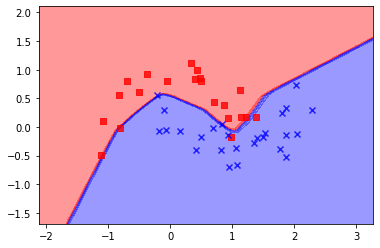

In [10]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

In [15]:
from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam_1 = History()
model = Sequential()
model.add(Dense(1000, use_bias=False,input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(500, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(200, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=4000, callbacks=[history_Adam_1])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1000)              2000      
_________________________________________________________________
batch_normalization_9 (Batch (None, 1000)              4000      
_________________________________________________________________
activation_9 (Activation)    (None, 1000)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 500)               500000    
_________________________________________________________________
batch_normalization_10 (Batc (None, 500)               2000      
_________________________________________________________________
activation_10 (Activation)   (None, 500)              

Epoch 102/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2065 - accuracy: 0.9057 - val_loss: 0.5983 - val_accuracy: 0.6383
Epoch 103/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.3152 - accuracy: 0.8679 - val_loss: 0.6022 - val_accuracy: 0.6383
Epoch 104/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2656 - accuracy: 0.8868 - val_loss: 0.6066 - val_accuracy: 0.6383
Epoch 105/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.3797 - accuracy: 0.8679 - val_loss: 0.6157 - val_accuracy: 0.6383
Epoch 106/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.3632 - accuracy: 0.8491 - val_loss: 0.6157 - val_accuracy: 0.6383
Epoch 107/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.3077 - accuracy: 0.8679 - val_loss: 0.6152 - val_accuracy: 0.6383
Epoch 108/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.2629 - accuracy: 0.8679 - val_loss: 0.6118 - val_accuracy: 0.6383

2/2 [==============================] - 0s 19ms/step - loss: 0.2336 - accuracy: 0.8679 - val_loss: 0.4212 - val_accuracy: 0.7872
Epoch 217/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.2501 - accuracy: 0.9057 - val_loss: 0.4208 - val_accuracy: 0.7872
Epoch 218/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.2737 - accuracy: 0.8679 - val_loss: 0.4206 - val_accuracy: 0.7872
Epoch 219/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2952 - accuracy: 0.8868 - val_loss: 0.4211 - val_accuracy: 0.7872
Epoch 220/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2768 - accuracy: 0.9057 - val_loss: 0.4220 - val_accuracy: 0.7872
Epoch 221/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.3857 - accuracy: 0.8868 - val_loss: 0.4240 - val_accuracy: 0.7872
Epoch 222/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.2139 - accuracy: 0.9057 - val_loss: 0.4247 - val_accuracy: 0.7872
Epoch 223/4000

2/2 [==============================] - 0s 19ms/step - loss: 0.2489 - accuracy: 0.9057 - val_loss: 0.4869 - val_accuracy: 0.8085
Epoch 331/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1901 - accuracy: 0.9245 - val_loss: 0.4839 - val_accuracy: 0.8085
Epoch 332/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2992 - accuracy: 0.8679 - val_loss: 0.4803 - val_accuracy: 0.8085
Epoch 333/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2465 - accuracy: 0.9057 - val_loss: 0.4754 - val_accuracy: 0.8085
Epoch 334/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2361 - accuracy: 0.8679 - val_loss: 0.4676 - val_accuracy: 0.8085
Epoch 335/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.2714 - accuracy: 0.9057 - val_loss: 0.4616 - val_accuracy: 0.8085
Epoch 336/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.3278 - accuracy: 0.8679 - val_loss: 0.4598 - val_accuracy: 0.8085
Epoch 337/4000

2/2 [==============================] - 0s 18ms/step - loss: 0.2667 - accuracy: 0.8679 - val_loss: 0.3947 - val_accuracy: 0.8298
Epoch 445/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2565 - accuracy: 0.8868 - val_loss: 0.3964 - val_accuracy: 0.8298
Epoch 446/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2176 - accuracy: 0.9245 - val_loss: 0.3999 - val_accuracy: 0.8298
Epoch 447/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2711 - accuracy: 0.8868 - val_loss: 0.4062 - val_accuracy: 0.8298
Epoch 448/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2065 - accuracy: 0.9245 - val_loss: 0.4096 - val_accuracy: 0.8298
Epoch 449/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.2631 - accuracy: 0.8868 - val_loss: 0.4158 - val_accuracy: 0.8085
Epoch 450/4000
2/2 [==============================] - 0s 23ms/step - loss: 0.2290 - accuracy: 0.9057 - val_loss: 0.4209 - val_accuracy: 0.8085
Epoch 451/4000

2/2 [==============================] - 0s 20ms/step - loss: 0.2075 - accuracy: 0.9245 - val_loss: 0.4037 - val_accuracy: 0.8511
Epoch 559/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.2293 - accuracy: 0.9245 - val_loss: 0.4117 - val_accuracy: 0.8298
Epoch 560/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.2378 - accuracy: 0.8868 - val_loss: 0.4179 - val_accuracy: 0.8511
Epoch 561/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2717 - accuracy: 0.8868 - val_loss: 0.4240 - val_accuracy: 0.8511
Epoch 562/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2817 - accuracy: 0.8491 - val_loss: 0.4236 - val_accuracy: 0.8511
Epoch 563/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.2768 - accuracy: 0.9245 - val_loss: 0.4297 - val_accuracy: 0.8511
Epoch 564/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2519 - accuracy: 0.8491 - val_loss: 0.4287 - val_accuracy: 0.8511
Epoch 565/4000

2/2 [==============================] - 0s 15ms/step - loss: 0.2381 - accuracy: 0.9057 - val_loss: 0.4404 - val_accuracy: 0.8085
Epoch 673/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2834 - accuracy: 0.9057 - val_loss: 0.4331 - val_accuracy: 0.8511
Epoch 674/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1947 - accuracy: 0.9057 - val_loss: 0.4153 - val_accuracy: 0.8511
Epoch 675/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2358 - accuracy: 0.9245 - val_loss: 0.3990 - val_accuracy: 0.8511
Epoch 676/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1359 - accuracy: 0.9623 - val_loss: 0.3759 - val_accuracy: 0.8723
Epoch 677/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1740 - accuracy: 0.9434 - val_loss: 0.3501 - val_accuracy: 0.8723
Epoch 678/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1359 - accuracy: 0.9434 - val_loss: 0.3277 - val_accuracy: 0.8511
Epoch 679/4000

2/2 [==============================] - 0s 21ms/step - loss: 0.2233 - accuracy: 0.9057 - val_loss: 0.2724 - val_accuracy: 0.8723
Epoch 787/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.2899 - accuracy: 0.9057 - val_loss: 0.2649 - val_accuracy: 0.8723
Epoch 788/4000
2/2 [==============================] - 0s 27ms/step - loss: 0.2161 - accuracy: 0.8868 - val_loss: 0.2564 - val_accuracy: 0.8723
Epoch 789/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.2085 - accuracy: 0.8868 - val_loss: 0.2500 - val_accuracy: 0.8723
Epoch 790/4000
2/2 [==============================] - 0s 25ms/step - loss: 0.2883 - accuracy: 0.8679 - val_loss: 0.2402 - val_accuracy: 0.8723
Epoch 791/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2638 - accuracy: 0.8868 - val_loss: 0.2332 - val_accuracy: 0.8723
Epoch 792/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2176 - accuracy: 0.9057 - val_loss: 0.2300 - val_accuracy: 0.8723
Epoch 793/4000

2/2 [==============================] - 0s 31ms/step - loss: 0.2707 - accuracy: 0.9057 - val_loss: 0.3630 - val_accuracy: 0.8723
Epoch 901/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.2527 - accuracy: 0.9057 - val_loss: 0.3515 - val_accuracy: 0.8723
Epoch 902/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.2206 - accuracy: 0.9057 - val_loss: 0.3453 - val_accuracy: 0.8723
Epoch 903/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.4477 - accuracy: 0.7925 - val_loss: 0.3545 - val_accuracy: 0.8723
Epoch 904/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2250 - accuracy: 0.9057 - val_loss: 0.3618 - val_accuracy: 0.8723
Epoch 905/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1780 - accuracy: 0.9434 - val_loss: 0.3634 - val_accuracy: 0.8723
Epoch 906/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.1595 - accuracy: 0.9623 - val_loss: 0.3610 - val_accuracy: 0.8723
Epoch 907/4000

Epoch 1014/4000
2/2 [==============================] - 0s 26ms/step - loss: 0.2120 - accuracy: 0.9434 - val_loss: 0.2709 - val_accuracy: 0.8723
Epoch 1015/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.2241 - accuracy: 0.8868 - val_loss: 0.2709 - val_accuracy: 0.8723
Epoch 1016/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1479 - accuracy: 0.9245 - val_loss: 0.2689 - val_accuracy: 0.8723
Epoch 1017/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1791 - accuracy: 0.9245 - val_loss: 0.2645 - val_accuracy: 0.8723
Epoch 1018/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.2540 - accuracy: 0.8868 - val_loss: 0.2642 - val_accuracy: 0.8723
Epoch 1019/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1900 - accuracy: 0.9057 - val_loss: 0.2706 - val_accuracy: 0.8723
Epoch 1020/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1787 - accuracy: 0.9245 - val_loss: 0.2891 - val_accuracy:

Epoch 1127/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.2036 - accuracy: 0.9623 - val_loss: 0.2822 - val_accuracy: 0.8723
Epoch 1128/4000
2/2 [==============================] - 0s 23ms/step - loss: 0.1764 - accuracy: 0.9245 - val_loss: 0.2768 - val_accuracy: 0.8723
Epoch 1129/4000
2/2 [==============================] - 0s 32ms/step - loss: 0.3026 - accuracy: 0.8491 - val_loss: 0.2607 - val_accuracy: 0.8723
Epoch 1130/4000
2/2 [==============================] - 0s 28ms/step - loss: 0.1744 - accuracy: 0.9434 - val_loss: 0.2446 - val_accuracy: 0.8723
Epoch 1131/4000
2/2 [==============================] - 0s 29ms/step - loss: 0.1844 - accuracy: 0.9245 - val_loss: 0.2337 - val_accuracy: 0.8723
Epoch 1132/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1856 - accuracy: 0.9057 - val_loss: 0.2217 - val_accuracy: 0.8723
Epoch 1133/4000
2/2 [==============================] - 0s 32ms/step - loss: 0.3617 - accuracy: 0.8491 - val_loss: 0.2174 - val_accuracy:

Epoch 1184/4000
2/2 [==============================] - 0s 32ms/step - loss: 0.1282 - accuracy: 0.9245 - val_loss: 0.2792 - val_accuracy: 0.8723
Epoch 1185/4000
2/2 [==============================] - 0s 24ms/step - loss: 0.1451 - accuracy: 0.9623 - val_loss: 0.2637 - val_accuracy: 0.8723
Epoch 1186/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1748 - accuracy: 0.9434 - val_loss: 0.2475 - val_accuracy: 0.8723
Epoch 1187/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2105 - accuracy: 0.9245 - val_loss: 0.2380 - val_accuracy: 0.8723
Epoch 1188/4000
2/2 [==============================] - 0s 48ms/step - loss: 0.2482 - accuracy: 0.8868 - val_loss: 0.2391 - val_accuracy: 0.8723
Epoch 1189/4000
2/2 [==============================] - 0s 27ms/step - loss: 0.1934 - accuracy: 0.9057 - val_loss: 0.2435 - val_accuracy: 0.8723
Epoch 1190/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1385 - accuracy: 0.9434 - val_loss: 0.2506 - val_accuracy:

Epoch 1241/4000
2/2 [==============================] - 0s 23ms/step - loss: 0.1690 - accuracy: 0.8868 - val_loss: 0.2820 - val_accuracy: 0.8723
Epoch 1242/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1531 - accuracy: 0.9434 - val_loss: 0.2766 - val_accuracy: 0.8723
Epoch 1243/4000
2/2 [==============================] - 0s 26ms/step - loss: 0.2130 - accuracy: 0.9434 - val_loss: 0.2728 - val_accuracy: 0.8723
Epoch 1244/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.1637 - accuracy: 0.9245 - val_loss: 0.2605 - val_accuracy: 0.8723
Epoch 1245/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1750 - accuracy: 0.9057 - val_loss: 0.2472 - val_accuracy: 0.8723
Epoch 1246/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.2578 - accuracy: 0.8679 - val_loss: 0.2402 - val_accuracy: 0.8723
Epoch 1247/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1899 - accuracy: 0.8868 - val_loss: 0.2370 - val_accuracy:

Epoch 1298/4000
2/2 [==============================] - 0s 24ms/step - loss: 0.1916 - accuracy: 0.9245 - val_loss: 0.2186 - val_accuracy: 0.8936
Epoch 1299/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.1872 - accuracy: 0.9057 - val_loss: 0.2311 - val_accuracy: 0.8723
Epoch 1300/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.1248 - accuracy: 0.9623 - val_loss: 0.2406 - val_accuracy: 0.8723
Epoch 1301/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1951 - accuracy: 0.9057 - val_loss: 0.2513 - val_accuracy: 0.8723
Epoch 1302/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1153 - accuracy: 0.9434 - val_loss: 0.2566 - val_accuracy: 0.8723
Epoch 1303/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2841 - accuracy: 0.9434 - val_loss: 0.2622 - val_accuracy: 0.8723
Epoch 1304/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1570 - accuracy: 0.9245 - val_loss: 0.2630 - val_accuracy:

Epoch 1355/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1490 - accuracy: 0.9434 - val_loss: 0.2924 - val_accuracy: 0.8723
Epoch 1356/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1058 - accuracy: 0.9434 - val_loss: 0.2998 - val_accuracy: 0.8723
Epoch 1357/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.0919 - accuracy: 0.9623 - val_loss: 0.3073 - val_accuracy: 0.8723
Epoch 1358/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1440 - accuracy: 0.9623 - val_loss: 0.3173 - val_accuracy: 0.8723
Epoch 1359/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2491 - accuracy: 0.9057 - val_loss: 0.3185 - val_accuracy: 0.8723
Epoch 1360/4000
2/2 [==============================] - 0s 25ms/step - loss: 0.1591 - accuracy: 0.9245 - val_loss: 0.3096 - val_accuracy: 0.8723
Epoch 1361/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1066 - accuracy: 0.9623 - val_loss: 0.3005 - val_accuracy:

Epoch 1412/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1605 - accuracy: 0.9434 - val_loss: 0.2453 - val_accuracy: 0.8723
Epoch 1413/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0916 - accuracy: 0.9811 - val_loss: 0.2388 - val_accuracy: 0.8723
Epoch 1414/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1161 - accuracy: 0.9623 - val_loss: 0.2335 - val_accuracy: 0.8723
Epoch 1415/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0876 - accuracy: 0.9811 - val_loss: 0.2265 - val_accuracy: 0.8723
Epoch 1416/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2577 - accuracy: 0.9057 - val_loss: 0.2268 - val_accuracy: 0.8723
Epoch 1417/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1555 - accuracy: 0.9434 - val_loss: 0.2173 - val_accuracy: 0.8723
Epoch 1418/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1112 - accuracy: 0.9245 - val_loss: 0.2126 - val_accuracy:

Epoch 1469/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1271 - accuracy: 0.9245 - val_loss: 0.2600 - val_accuracy: 0.8723
Epoch 1470/4000
2/2 [==============================] - 0s 28ms/step - loss: 0.1617 - accuracy: 0.9434 - val_loss: 0.2578 - val_accuracy: 0.8723
Epoch 1471/4000
2/2 [==============================] - 0s 23ms/step - loss: 0.1200 - accuracy: 0.9434 - val_loss: 0.2521 - val_accuracy: 0.8723
Epoch 1472/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1356 - accuracy: 0.9434 - val_loss: 0.2451 - val_accuracy: 0.8723
Epoch 1473/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1050 - accuracy: 0.9623 - val_loss: 0.2364 - val_accuracy: 0.8723
Epoch 1474/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.3139 - accuracy: 0.8302 - val_loss: 0.2341 - val_accuracy: 0.8723
Epoch 1475/4000
2/2 [==============================] - 0s 25ms/step - loss: 0.1613 - accuracy: 0.9434 - val_loss: 0.2296 - val_accuracy:

Epoch 1526/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1974 - accuracy: 0.8868 - val_loss: 0.2343 - val_accuracy: 0.8723
Epoch 1527/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1907 - accuracy: 0.9245 - val_loss: 0.2408 - val_accuracy: 0.8723
Epoch 1528/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1164 - accuracy: 0.9623 - val_loss: 0.2425 - val_accuracy: 0.8723
Epoch 1529/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1607 - accuracy: 0.9245 - val_loss: 0.2408 - val_accuracy: 0.8723
Epoch 1530/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2576 - accuracy: 0.8868 - val_loss: 0.2385 - val_accuracy: 0.8723
Epoch 1531/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1436 - accuracy: 0.9434 - val_loss: 0.2374 - val_accuracy: 0.8723
Epoch 1532/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1967 - accuracy: 0.9245 - val_loss: 0.2460 - val_accuracy:

Epoch 1583/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2182 - accuracy: 0.9245 - val_loss: 0.3014 - val_accuracy: 0.8723
Epoch 1584/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2016 - accuracy: 0.9057 - val_loss: 0.2930 - val_accuracy: 0.8723
Epoch 1585/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1804 - accuracy: 0.9245 - val_loss: 0.2794 - val_accuracy: 0.8723
Epoch 1586/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2517 - accuracy: 0.8868 - val_loss: 0.2668 - val_accuracy: 0.8723
Epoch 1587/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1227 - accuracy: 0.9623 - val_loss: 0.2557 - val_accuracy: 0.8723
Epoch 1588/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1687 - accuracy: 0.9434 - val_loss: 0.2488 - val_accuracy: 0.8723
Epoch 1589/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1655 - accuracy: 0.9434 - val_loss: 0.2433 - val_accuracy:

Epoch 1640/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1319 - accuracy: 0.9623 - val_loss: 0.1772 - val_accuracy: 0.9362
Epoch 1641/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1618 - accuracy: 0.9245 - val_loss: 0.1796 - val_accuracy: 0.9362
Epoch 1642/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.2497 - accuracy: 0.9245 - val_loss: 0.1836 - val_accuracy: 0.9362
Epoch 1643/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1345 - accuracy: 0.9434 - val_loss: 0.1864 - val_accuracy: 0.9149
Epoch 1644/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1301 - accuracy: 0.9434 - val_loss: 0.1897 - val_accuracy: 0.9149
Epoch 1645/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1464 - accuracy: 0.9245 - val_loss: 0.1912 - val_accuracy: 0.9149
Epoch 1646/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.2126 - accuracy: 0.9057 - val_loss: 0.1938 - val_accuracy:

Epoch 1697/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1699 - accuracy: 0.9434 - val_loss: 0.2441 - val_accuracy: 0.8723
Epoch 1698/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1870 - accuracy: 0.9434 - val_loss: 0.2466 - val_accuracy: 0.8723
Epoch 1699/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1702 - accuracy: 0.9434 - val_loss: 0.2461 - val_accuracy: 0.8723
Epoch 1700/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1981 - accuracy: 0.9245 - val_loss: 0.2415 - val_accuracy: 0.8936
Epoch 1701/4000
2/2 [==============================] - 0s 29ms/step - loss: 0.1495 - accuracy: 0.9245 - val_loss: 0.2395 - val_accuracy: 0.8936
Epoch 1702/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.0957 - accuracy: 0.9434 - val_loss: 0.2345 - val_accuracy: 0.8936
Epoch 1703/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1089 - accuracy: 0.9434 - val_loss: 0.2288 - val_accuracy:

Epoch 1754/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1649 - accuracy: 0.9623 - val_loss: 0.2814 - val_accuracy: 0.8723
Epoch 1755/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2012 - accuracy: 0.9245 - val_loss: 0.2860 - val_accuracy: 0.8723
Epoch 1756/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1207 - accuracy: 0.9623 - val_loss: 0.2935 - val_accuracy: 0.8723
Epoch 1757/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0844 - accuracy: 0.9811 - val_loss: 0.2999 - val_accuracy: 0.8723
Epoch 1758/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0967 - accuracy: 0.9811 - val_loss: 0.3032 - val_accuracy: 0.8723
Epoch 1759/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1418 - accuracy: 0.9434 - val_loss: 0.3039 - val_accuracy: 0.8723
Epoch 1760/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1007 - accuracy: 0.9811 - val_loss: 0.3047 - val_accuracy:

Epoch 1811/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0994 - accuracy: 0.9811 - val_loss: 0.2161 - val_accuracy: 0.8936
Epoch 1812/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1234 - accuracy: 0.9434 - val_loss: 0.2236 - val_accuracy: 0.8936
Epoch 1813/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1198 - accuracy: 0.9245 - val_loss: 0.2271 - val_accuracy: 0.8936
Epoch 1814/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2542 - accuracy: 0.8868 - val_loss: 0.2384 - val_accuracy: 0.8723
Epoch 1815/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0987 - accuracy: 0.9623 - val_loss: 0.2482 - val_accuracy: 0.8723
Epoch 1816/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1207 - accuracy: 0.9811 - val_loss: 0.2579 - val_accuracy: 0.8723
Epoch 1817/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1583 - accuracy: 0.9434 - val_loss: 0.2604 - val_accuracy:

2/2 [==============================] - 0s 19ms/step - loss: 0.1469 - accuracy: 0.9057 - val_loss: 0.2984 - val_accuracy: 0.8723
Epoch 1868/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1253 - accuracy: 0.9434 - val_loss: 0.2873 - val_accuracy: 0.8723
Epoch 1869/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2317 - accuracy: 0.9057 - val_loss: 0.2774 - val_accuracy: 0.8723
Epoch 1870/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1761 - accuracy: 0.9434 - val_loss: 0.2658 - val_accuracy: 0.8723
Epoch 1871/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1534 - accuracy: 0.9623 - val_loss: 0.2577 - val_accuracy: 0.8723
Epoch 1872/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0596 - accuracy: 0.9811 - val_loss: 0.2480 - val_accuracy: 0.8723
Epoch 1873/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2256 - accuracy: 0.9057 - val_loss: 0.2413 - val_accuracy: 0.8723
Epoch 18

2/2 [==============================] - 0s 19ms/step - loss: 0.1259 - accuracy: 0.9623 - val_loss: 0.1836 - val_accuracy: 0.9149
Epoch 1925/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1128 - accuracy: 0.9434 - val_loss: 0.1875 - val_accuracy: 0.9149
Epoch 1926/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1652 - accuracy: 0.9434 - val_loss: 0.1936 - val_accuracy: 0.9149
Epoch 1927/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0672 - accuracy: 0.9811 - val_loss: 0.1991 - val_accuracy: 0.9149
Epoch 1928/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1542 - accuracy: 0.9245 - val_loss: 0.2075 - val_accuracy: 0.8936
Epoch 1929/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0751 - accuracy: 0.9623 - val_loss: 0.2137 - val_accuracy: 0.8936
Epoch 1930/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2187 - accuracy: 0.8679 - val_loss: 0.2157 - val_accuracy: 0.8936
Epoch 19

2/2 [==============================] - 0s 18ms/step - loss: 0.1157 - accuracy: 0.9623 - val_loss: 0.1946 - val_accuracy: 0.8936
Epoch 1982/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2685 - accuracy: 0.9057 - val_loss: 0.1974 - val_accuracy: 0.8936
Epoch 1983/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1333 - accuracy: 0.9434 - val_loss: 0.2026 - val_accuracy: 0.8936
Epoch 1984/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1593 - accuracy: 0.9057 - val_loss: 0.2023 - val_accuracy: 0.8936
Epoch 1985/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1167 - accuracy: 0.9623 - val_loss: 0.2092 - val_accuracy: 0.8936
Epoch 1986/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1502 - accuracy: 0.9245 - val_loss: 0.2141 - val_accuracy: 0.8936
Epoch 1987/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1680 - accuracy: 0.9057 - val_loss: 0.2154 - val_accuracy: 0.8936
Epoch 19

2/2 [==============================] - 0s 17ms/step - loss: 0.1129 - accuracy: 0.9434 - val_loss: 0.2785 - val_accuracy: 0.8723
Epoch 2039/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1287 - accuracy: 0.9245 - val_loss: 0.2695 - val_accuracy: 0.8723
Epoch 2040/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0748 - accuracy: 0.9811 - val_loss: 0.2614 - val_accuracy: 0.8723
Epoch 2041/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0843 - accuracy: 0.9623 - val_loss: 0.2508 - val_accuracy: 0.8936
Epoch 2042/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1263 - accuracy: 0.9623 - val_loss: 0.2378 - val_accuracy: 0.8936
Epoch 2043/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1039 - accuracy: 0.9623 - val_loss: 0.2273 - val_accuracy: 0.8936
Epoch 2044/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2253 - accuracy: 0.9057 - val_loss: 0.2153 - val_accuracy: 0.8936
Epoch 20

2/2 [==============================] - 0s 17ms/step - loss: 0.0738 - accuracy: 0.9623 - val_loss: 0.1926 - val_accuracy: 0.8936
Epoch 2096/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0676 - accuracy: 0.9811 - val_loss: 0.1864 - val_accuracy: 0.9149
Epoch 2097/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0785 - accuracy: 0.9811 - val_loss: 0.1801 - val_accuracy: 0.9362
Epoch 2098/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1237 - accuracy: 0.9434 - val_loss: 0.1776 - val_accuracy: 0.9362
Epoch 2099/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1967 - accuracy: 0.9057 - val_loss: 0.1853 - val_accuracy: 0.9362
Epoch 2100/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0768 - accuracy: 0.9811 - val_loss: 0.1961 - val_accuracy: 0.9149
Epoch 2101/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0803 - accuracy: 1.0000 - val_loss: 0.2077 - val_accuracy: 0.9149
Epoch 21

2/2 [==============================] - 0s 19ms/step - loss: 0.0800 - accuracy: 0.9623 - val_loss: 0.1827 - val_accuracy: 0.9149
Epoch 2153/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0800 - accuracy: 0.9811 - val_loss: 0.1893 - val_accuracy: 0.9149
Epoch 2154/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0988 - accuracy: 0.9245 - val_loss: 0.1928 - val_accuracy: 0.8936
Epoch 2155/4000
2/2 [==============================] - 0s 24ms/step - loss: 0.1730 - accuracy: 0.9057 - val_loss: 0.1990 - val_accuracy: 0.8936
Epoch 2156/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1123 - accuracy: 0.9811 - val_loss: 0.2101 - val_accuracy: 0.8936
Epoch 2157/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1092 - accuracy: 0.9623 - val_loss: 0.2224 - val_accuracy: 0.8936
Epoch 2158/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1291 - accuracy: 0.9623 - val_loss: 0.2322 - val_accuracy: 0.8936
Epoch 21

Epoch 2209/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1132 - accuracy: 0.9434 - val_loss: 0.1856 - val_accuracy: 0.9149
Epoch 2210/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1288 - accuracy: 0.9434 - val_loss: 0.1950 - val_accuracy: 0.9149
Epoch 2211/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.3717 - accuracy: 0.8491 - val_loss: 0.2130 - val_accuracy: 0.8936
Epoch 2212/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.0713 - accuracy: 0.9811 - val_loss: 0.2370 - val_accuracy: 0.8936
Epoch 2213/4000
2/2 [==============================] - 0s 24ms/step - loss: 0.2139 - accuracy: 0.8868 - val_loss: 0.2593 - val_accuracy: 0.8723
Epoch 2214/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1846 - accuracy: 0.8868 - val_loss: 0.2729 - val_accuracy: 0.8723
Epoch 2215/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0989 - accuracy: 0.9623 - val_loss: 0.2862 - val_accuracy:

Epoch 2266/4000
2/2 [==============================] - 0s 23ms/step - loss: 0.1086 - accuracy: 0.9434 - val_loss: 0.2299 - val_accuracy: 0.8936
Epoch 2267/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1308 - accuracy: 0.9245 - val_loss: 0.2208 - val_accuracy: 0.8936
Epoch 2268/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0875 - accuracy: 0.9623 - val_loss: 0.2105 - val_accuracy: 0.8936
Epoch 2269/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1181 - accuracy: 0.9623 - val_loss: 0.1990 - val_accuracy: 0.9149
Epoch 2270/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0633 - accuracy: 0.9623 - val_loss: 0.1912 - val_accuracy: 0.9149
Epoch 2271/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1196 - accuracy: 0.9434 - val_loss: 0.1833 - val_accuracy: 0.9149
Epoch 2272/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1156 - accuracy: 0.9623 - val_loss: 0.1774 - val_accuracy:

Epoch 2323/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1164 - accuracy: 0.9623 - val_loss: 0.1894 - val_accuracy: 0.9149
Epoch 2324/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1197 - accuracy: 0.9434 - val_loss: 0.1813 - val_accuracy: 0.9149
Epoch 2325/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2833 - accuracy: 0.9245 - val_loss: 0.1780 - val_accuracy: 0.9149
Epoch 2326/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1462 - accuracy: 0.9434 - val_loss: 0.1768 - val_accuracy: 0.9149
Epoch 2327/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.2170 - accuracy: 0.9245 - val_loss: 0.1816 - val_accuracy: 0.9149
Epoch 2328/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0961 - accuracy: 0.9623 - val_loss: 0.1865 - val_accuracy: 0.9149
Epoch 2329/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1535 - accuracy: 0.9434 - val_loss: 0.1931 - val_accuracy:

Epoch 2380/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2503 - accuracy: 0.8679 - val_loss: 0.2037 - val_accuracy: 0.8936
Epoch 2381/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1473 - accuracy: 0.9434 - val_loss: 0.2020 - val_accuracy: 0.8936
Epoch 2382/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.1582 - accuracy: 0.9057 - val_loss: 0.1997 - val_accuracy: 0.8936
Epoch 2383/4000
2/2 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.93 - 0s 20ms/step - loss: 0.0830 - accuracy: 0.9623 - val_loss: 0.1967 - val_accuracy: 0.8936
Epoch 2384/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.1815 - accuracy: 0.9057 - val_loss: 0.1993 - val_accuracy: 0.8936
Epoch 2385/4000
2/2 [==============================] - 0s 24ms/step - loss: 0.1010 - accuracy: 0.9434 - val_loss: 0.2076 - val_accuracy: 0.8936
Epoch 2386/4000
2/2 [==============================] - 0s 27ms/step - loss: 0.1342 - accuracy:

Epoch 2493/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.1108 - accuracy: 0.9623 - val_loss: 0.2026 - val_accuracy: 0.8936
Epoch 2494/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1263 - accuracy: 0.9245 - val_loss: 0.1970 - val_accuracy: 0.8936
Epoch 2495/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2335 - accuracy: 0.8868 - val_loss: 0.2023 - val_accuracy: 0.8936
Epoch 2496/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1337 - accuracy: 0.9434 - val_loss: 0.2151 - val_accuracy: 0.8936
Epoch 2497/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1660 - accuracy: 0.9434 - val_loss: 0.2304 - val_accuracy: 0.8936
Epoch 2498/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1190 - accuracy: 0.9623 - val_loss: 0.2410 - val_accuracy: 0.8936
Epoch 2499/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1168 - accuracy: 0.9434 - val_loss: 0.2489 - val_accuracy:

Epoch 2550/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0786 - accuracy: 0.9811 - val_loss: 0.2788 - val_accuracy: 0.8723
Epoch 2551/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0908 - accuracy: 0.9434 - val_loss: 0.2814 - val_accuracy: 0.8723
Epoch 2552/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1314 - accuracy: 0.9434 - val_loss: 0.2849 - val_accuracy: 0.8723
Epoch 2553/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0970 - accuracy: 0.9811 - val_loss: 0.2870 - val_accuracy: 0.8723
Epoch 2554/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1375 - accuracy: 0.9434 - val_loss: 0.2864 - val_accuracy: 0.8723
Epoch 2555/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0949 - accuracy: 0.9623 - val_loss: 0.2855 - val_accuracy: 0.8723
Epoch 2556/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1469 - accuracy: 0.9434 - val_loss: 0.2825 - val_accuracy:

Epoch 2607/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1298 - accuracy: 0.9434 - val_loss: 0.1633 - val_accuracy: 0.9362
Epoch 2608/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1457 - accuracy: 0.9057 - val_loss: 0.1721 - val_accuracy: 0.9149
Epoch 2609/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1407 - accuracy: 0.9434 - val_loss: 0.1789 - val_accuracy: 0.9149
Epoch 2610/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0941 - accuracy: 0.9434 - val_loss: 0.1864 - val_accuracy: 0.9149
Epoch 2611/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.2757 - accuracy: 0.9057 - val_loss: 0.1962 - val_accuracy: 0.8936
Epoch 2612/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2257 - accuracy: 0.9245 - val_loss: 0.2059 - val_accuracy: 0.8936
Epoch 2613/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0970 - accuracy: 0.9623 - val_loss: 0.2128 - val_accuracy:

Epoch 2664/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1741 - accuracy: 0.9434 - val_loss: 0.1715 - val_accuracy: 0.9149
Epoch 2665/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0586 - accuracy: 0.9811 - val_loss: 0.1668 - val_accuracy: 0.9149
Epoch 2666/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1025 - accuracy: 0.9623 - val_loss: 0.1644 - val_accuracy: 0.9362
Epoch 2667/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1504 - accuracy: 0.9057 - val_loss: 0.1598 - val_accuracy: 0.9362
Epoch 2668/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0761 - accuracy: 0.9811 - val_loss: 0.1559 - val_accuracy: 0.9362
Epoch 2669/4000
2/2 [==============================] - 0s 23ms/step - loss: 0.1424 - accuracy: 0.9057 - val_loss: 0.1541 - val_accuracy: 0.9362
Epoch 2670/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2931 - accuracy: 0.8679 - val_loss: 0.1552 - val_accuracy:

Epoch 2721/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1708 - accuracy: 0.9623 - val_loss: 0.1820 - val_accuracy: 0.9149
Epoch 2722/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0868 - accuracy: 0.9623 - val_loss: 0.1878 - val_accuracy: 0.9149
Epoch 2723/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1288 - accuracy: 0.9811 - val_loss: 0.1920 - val_accuracy: 0.8936
Epoch 2724/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1255 - accuracy: 0.9245 - val_loss: 0.1953 - val_accuracy: 0.8936
Epoch 2725/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2526 - accuracy: 0.9057 - val_loss: 0.1972 - val_accuracy: 0.8936
Epoch 2726/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1089 - accuracy: 0.9434 - val_loss: 0.1948 - val_accuracy: 0.8936
Epoch 2727/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1427 - accuracy: 0.9245 - val_loss: 0.1950 - val_accuracy:

Epoch 2778/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1323 - accuracy: 0.9434 - val_loss: 0.2071 - val_accuracy: 0.8936
Epoch 2779/4000
2/2 [==============================] - 0s 27ms/step - loss: 0.1280 - accuracy: 0.9434 - val_loss: 0.1980 - val_accuracy: 0.9149
Epoch 2780/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1602 - accuracy: 0.9245 - val_loss: 0.1899 - val_accuracy: 0.9149
Epoch 2781/4000
2/2 [==============================] - 0s 24ms/step - loss: 0.0730 - accuracy: 0.9811 - val_loss: 0.1809 - val_accuracy: 0.9149
Epoch 2782/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1926 - accuracy: 0.8868 - val_loss: 0.1738 - val_accuracy: 0.9149
Epoch 2783/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0947 - accuracy: 0.9434 - val_loss: 0.1690 - val_accuracy: 0.9362
Epoch 2784/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.0868 - accuracy: 0.9811 - val_loss: 0.1704 - val_accuracy:

Epoch 2835/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1448 - accuracy: 0.9434 - val_loss: 0.1668 - val_accuracy: 0.9362
Epoch 2836/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1434 - accuracy: 0.9245 - val_loss: 0.1615 - val_accuracy: 0.9362
Epoch 2837/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1323 - accuracy: 0.9245 - val_loss: 0.1613 - val_accuracy: 0.9149
Epoch 2838/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1621 - accuracy: 0.9057 - val_loss: 0.1646 - val_accuracy: 0.9362
Epoch 2839/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0875 - accuracy: 0.9623 - val_loss: 0.1673 - val_accuracy: 0.9149
Epoch 2840/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0368 - accuracy: 1.0000 - val_loss: 0.1697 - val_accuracy: 0.9149
Epoch 2841/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.2334 - accuracy: 0.8868 - val_loss: 0.1700 - val_accuracy:

Epoch 2892/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1137 - accuracy: 0.9623 - val_loss: 0.1768 - val_accuracy: 0.9149
Epoch 2893/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1498 - accuracy: 0.9434 - val_loss: 0.1725 - val_accuracy: 0.9149
Epoch 2894/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1131 - accuracy: 0.9623 - val_loss: 0.1763 - val_accuracy: 0.9149
Epoch 2895/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1440 - accuracy: 0.9057 - val_loss: 0.1849 - val_accuracy: 0.9149
Epoch 2896/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1237 - accuracy: 0.9623 - val_loss: 0.1946 - val_accuracy: 0.9149
Epoch 2897/4000
2/2 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.96 - 0s 16ms/step - loss: 0.1652 - accuracy: 0.9245 - val_loss: 0.2054 - val_accuracy: 0.8936
Epoch 2898/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1025 - accuracy:

Epoch 3005/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1446 - accuracy: 0.9245 - val_loss: 0.1981 - val_accuracy: 0.9149
Epoch 3006/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1536 - accuracy: 0.9434 - val_loss: 0.1935 - val_accuracy: 0.9149
Epoch 3007/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.2733 - accuracy: 0.8679 - val_loss: 0.1883 - val_accuracy: 0.9149
Epoch 3008/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2216 - accuracy: 0.9245 - val_loss: 0.1861 - val_accuracy: 0.9149
Epoch 3009/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1829 - accuracy: 0.9245 - val_loss: 0.1820 - val_accuracy: 0.9362
Epoch 3010/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1386 - accuracy: 0.9057 - val_loss: 0.1776 - val_accuracy: 0.9362
Epoch 3011/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1798 - accuracy: 0.9057 - val_loss: 0.1749 - val_accuracy:

Epoch 3062/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.0725 - accuracy: 0.9811 - val_loss: 0.1793 - val_accuracy: 0.9149
Epoch 3063/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1855 - accuracy: 0.9434 - val_loss: 0.1859 - val_accuracy: 0.9149
Epoch 3064/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1237 - accuracy: 0.9245 - val_loss: 0.1866 - val_accuracy: 0.9149
Epoch 3065/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2100 - accuracy: 0.9245 - val_loss: 0.1875 - val_accuracy: 0.9149
Epoch 3066/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1856 - accuracy: 0.9434 - val_loss: 0.1861 - val_accuracy: 0.9149
Epoch 3067/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2489 - accuracy: 0.8868 - val_loss: 0.1889 - val_accuracy: 0.9149
Epoch 3068/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1196 - accuracy: 0.9623 - val_loss: 0.1939 - val_accuracy:

Epoch 3175/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1951 - accuracy: 0.9245 - val_loss: 0.1889 - val_accuracy: 0.9149
Epoch 3176/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1529 - accuracy: 0.9434 - val_loss: 0.1830 - val_accuracy: 0.9149
Epoch 3177/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0766 - accuracy: 0.9623 - val_loss: 0.1782 - val_accuracy: 0.9149
Epoch 3178/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.3844 - accuracy: 0.8302 - val_loss: 0.1719 - val_accuracy: 0.9149
Epoch 3179/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1646 - accuracy: 0.9434 - val_loss: 0.1692 - val_accuracy: 0.9149
Epoch 3180/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0898 - accuracy: 0.9434 - val_loss: 0.1679 - val_accuracy: 0.9149
Epoch 3181/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0739 - accuracy: 0.9811 - val_loss: 0.1663 - val_accuracy:

Epoch 3232/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2941 - accuracy: 0.9057 - val_loss: 0.2265 - val_accuracy: 0.8936
Epoch 3233/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0924 - accuracy: 0.9623 - val_loss: 0.2244 - val_accuracy: 0.8936
Epoch 3234/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2939 - accuracy: 0.9057 - val_loss: 0.2252 - val_accuracy: 0.8936
Epoch 3235/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1487 - accuracy: 0.9245 - val_loss: 0.2262 - val_accuracy: 0.8936
Epoch 3236/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2998 - accuracy: 0.8868 - val_loss: 0.2287 - val_accuracy: 0.8936
Epoch 3237/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1584 - accuracy: 0.9245 - val_loss: 0.2367 - val_accuracy: 0.8936
Epoch 3238/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0763 - accuracy: 0.9623 - val_loss: 0.2432 - val_accuracy:

Epoch 3289/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.2784 - accuracy: 0.9245 - val_loss: 0.1955 - val_accuracy: 0.9149
Epoch 3290/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.1786 - accuracy: 0.9057 - val_loss: 0.1965 - val_accuracy: 0.9149
Epoch 3291/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.1626 - accuracy: 0.9623 - val_loss: 0.1964 - val_accuracy: 0.9149
Epoch 3292/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0756 - accuracy: 0.9811 - val_loss: 0.1968 - val_accuracy: 0.9149
Epoch 3293/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2186 - accuracy: 0.9057 - val_loss: 0.1961 - val_accuracy: 0.9149
Epoch 3294/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1565 - accuracy: 0.9434 - val_loss: 0.1969 - val_accuracy: 0.9149
Epoch 3295/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1287 - accuracy: 0.9434 - val_loss: 0.1949 - val_accuracy:

Epoch 3346/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1478 - accuracy: 0.9434 - val_loss: 0.1897 - val_accuracy: 0.9149
Epoch 3347/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1102 - accuracy: 0.9434 - val_loss: 0.1921 - val_accuracy: 0.9149
Epoch 3348/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0856 - accuracy: 0.9623 - val_loss: 0.1918 - val_accuracy: 0.9149
Epoch 3349/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1502 - accuracy: 0.9245 - val_loss: 0.1922 - val_accuracy: 0.9149
Epoch 3350/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1120 - accuracy: 0.9434 - val_loss: 0.1943 - val_accuracy: 0.9149
Epoch 3351/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.2246 - accuracy: 0.9057 - val_loss: 0.2003 - val_accuracy: 0.9149
Epoch 3352/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0807 - accuracy: 0.9623 - val_loss: 0.2083 - val_accuracy:

Epoch 3403/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1256 - accuracy: 0.9434 - val_loss: 0.2080 - val_accuracy: 0.8936
Epoch 3404/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0843 - accuracy: 0.9811 - val_loss: 0.2102 - val_accuracy: 0.8936
Epoch 3405/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1250 - accuracy: 0.9434 - val_loss: 0.2112 - val_accuracy: 0.8936
Epoch 3406/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1258 - accuracy: 0.9434 - val_loss: 0.2162 - val_accuracy: 0.8936
Epoch 3407/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1377 - accuracy: 0.9245 - val_loss: 0.2190 - val_accuracy: 0.8936
Epoch 3408/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1641 - accuracy: 0.9057 - val_loss: 0.2169 - val_accuracy: 0.8936
Epoch 3409/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1495 - accuracy: 0.9057 - val_loss: 0.2144 - val_accuracy:

Epoch 3460/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1163 - accuracy: 0.9245 - val_loss: 0.1784 - val_accuracy: 0.9362
Epoch 3461/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1365 - accuracy: 0.9623 - val_loss: 0.1794 - val_accuracy: 0.9362
Epoch 3462/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0688 - accuracy: 0.9811 - val_loss: 0.1785 - val_accuracy: 0.9362
Epoch 3463/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0744 - accuracy: 0.9623 - val_loss: 0.1777 - val_accuracy: 0.9362
Epoch 3464/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0671 - accuracy: 0.9811 - val_loss: 0.1760 - val_accuracy: 0.9362
Epoch 3465/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0462 - accuracy: 0.9811 - val_loss: 0.1747 - val_accuracy: 0.9149
Epoch 3466/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1872 - accuracy: 0.9245 - val_loss: 0.1764 - val_accuracy:

Epoch 3517/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.1938 - accuracy: 0.9057 - val_loss: 0.1833 - val_accuracy: 0.9149
Epoch 3518/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1147 - accuracy: 0.9623 - val_loss: 0.1861 - val_accuracy: 0.9149
Epoch 3519/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1556 - accuracy: 0.9057 - val_loss: 0.1855 - val_accuracy: 0.9149
Epoch 3520/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.1655 - accuracy: 0.9434 - val_loss: 0.1841 - val_accuracy: 0.9149
Epoch 3521/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0447 - accuracy: 1.0000 - val_loss: 0.1837 - val_accuracy: 0.9149
Epoch 3522/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1864 - accuracy: 0.9623 - val_loss: 0.1860 - val_accuracy: 0.9149
Epoch 3523/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2280 - accuracy: 0.8868 - val_loss: 0.1818 - val_accuracy:

Epoch 3574/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0573 - accuracy: 0.9811 - val_loss: 0.2252 - val_accuracy: 0.8936
Epoch 3575/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1097 - accuracy: 0.9811 - val_loss: 0.2226 - val_accuracy: 0.8936
Epoch 3576/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0964 - accuracy: 0.9434 - val_loss: 0.2217 - val_accuracy: 0.8936
Epoch 3577/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0964 - accuracy: 0.9811 - val_loss: 0.2187 - val_accuracy: 0.9149
Epoch 3578/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1330 - accuracy: 0.9057 - val_loss: 0.2177 - val_accuracy: 0.9149
Epoch 3579/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1283 - accuracy: 0.9434 - val_loss: 0.2138 - val_accuracy: 0.9149
Epoch 3580/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0643 - accuracy: 0.9623 - val_loss: 0.2095 - val_accuracy:

Epoch 3631/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1858 - accuracy: 0.9245 - val_loss: 0.1668 - val_accuracy: 0.9149
Epoch 3632/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2063 - accuracy: 0.8868 - val_loss: 0.1674 - val_accuracy: 0.9149
Epoch 3633/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0778 - accuracy: 0.9811 - val_loss: 0.1678 - val_accuracy: 0.9149
Epoch 3634/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2196 - accuracy: 0.9245 - val_loss: 0.1685 - val_accuracy: 0.9149
Epoch 3635/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0450 - accuracy: 1.0000 - val_loss: 0.1680 - val_accuracy: 0.9149
Epoch 3636/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1328 - accuracy: 0.9434 - val_loss: 0.1690 - val_accuracy: 0.9149
Epoch 3637/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.2683 - accuracy: 0.8868 - val_loss: 0.1718 - val_accuracy:

Epoch 3688/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.0548 - accuracy: 0.9811 - val_loss: 0.2027 - val_accuracy: 0.9149
Epoch 3689/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0577 - accuracy: 0.9811 - val_loss: 0.2009 - val_accuracy: 0.9149
Epoch 3690/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0382 - accuracy: 1.0000 - val_loss: 0.2027 - val_accuracy: 0.9149
Epoch 3691/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1400 - accuracy: 0.9623 - val_loss: 0.2059 - val_accuracy: 0.9149
Epoch 3692/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0708 - accuracy: 0.9811 - val_loss: 0.2037 - val_accuracy: 0.9149
Epoch 3693/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1054 - accuracy: 0.9623 - val_loss: 0.2004 - val_accuracy: 0.9149
Epoch 3694/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0978 - accuracy: 0.9434 - val_loss: 0.1985 - val_accuracy:

2/2 [==============================] - 0s 17ms/step - loss: 0.0615 - accuracy: 0.9811 - val_loss: 0.1741 - val_accuracy: 0.9362
Epoch 3802/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0754 - accuracy: 0.9623 - val_loss: 0.1686 - val_accuracy: 0.9362
Epoch 3803/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2506 - accuracy: 0.8679 - val_loss: 0.1732 - val_accuracy: 0.9362
Epoch 3804/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2635 - accuracy: 0.8491 - val_loss: 0.1762 - val_accuracy: 0.9149
Epoch 3805/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0302 - accuracy: 1.0000 - val_loss: 0.1753 - val_accuracy: 0.9149
Epoch 3806/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1307 - accuracy: 0.9434 - val_loss: 0.1780 - val_accuracy: 0.9149
Epoch 3807/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1143 - accuracy: 0.9245 - val_loss: 0.1807 - val_accuracy: 0.9149
Epoch 38

2/2 [==============================] - 0s 18ms/step - loss: 0.0762 - accuracy: 0.9623 - val_loss: 0.2568 - val_accuracy: 0.8936
Epoch 3859/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0643 - accuracy: 0.9811 - val_loss: 0.2552 - val_accuracy: 0.8936
Epoch 3860/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1601 - accuracy: 0.9245 - val_loss: 0.2508 - val_accuracy: 0.8936
Epoch 3861/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1660 - accuracy: 0.9245 - val_loss: 0.2381 - val_accuracy: 0.8936
Epoch 3862/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1915 - accuracy: 0.9245 - val_loss: 0.2221 - val_accuracy: 0.8936
Epoch 3863/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0365 - accuracy: 1.0000 - val_loss: 0.2091 - val_accuracy: 0.9149
Epoch 3864/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0472 - accuracy: 0.9811 - val_loss: 0.2002 - val_accuracy: 0.9149
Epoch 38

2/2 [==============================] - 0s 22ms/step - loss: 0.1752 - accuracy: 0.9245 - val_loss: 0.3313 - val_accuracy: 0.8723
Epoch 3916/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.1180 - accuracy: 0.9623 - val_loss: 0.3244 - val_accuracy: 0.8723
Epoch 3917/4000
2/2 [==============================] - 0s 25ms/step - loss: 0.2314 - accuracy: 0.8868 - val_loss: 0.3163 - val_accuracy: 0.8723
Epoch 3918/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.1365 - accuracy: 0.9623 - val_loss: 0.3060 - val_accuracy: 0.8723
Epoch 3919/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1090 - accuracy: 0.9623 - val_loss: 0.2871 - val_accuracy: 0.8936
Epoch 3920/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1275 - accuracy: 0.9434 - val_loss: 0.2697 - val_accuracy: 0.8936
Epoch 3921/4000
2/2 [==============================] - 0s 24ms/step - loss: 0.1078 - accuracy: 0.9623 - val_loss: 0.2509 - val_accuracy: 0.8936
Epoch 39

2/2 [==============================] - 0s 17ms/step - loss: 0.1365 - accuracy: 0.9434 - val_loss: 0.1550 - val_accuracy: 0.9149
Epoch 3973/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1121 - accuracy: 0.9811 - val_loss: 0.1526 - val_accuracy: 0.9149
Epoch 3974/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0636 - accuracy: 1.0000 - val_loss: 0.1517 - val_accuracy: 0.9149
Epoch 3975/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0779 - accuracy: 0.9811 - val_loss: 0.1499 - val_accuracy: 0.9149
Epoch 3976/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1670 - accuracy: 0.9434 - val_loss: 0.1484 - val_accuracy: 0.9149
Epoch 3977/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1247 - accuracy: 0.9623 - val_loss: 0.1489 - val_accuracy: 0.9149
Epoch 3978/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1352 - accuracy: 0.9434 - val_loss: 0.1511 - val_accuracy: 0.9149
Epoch 39

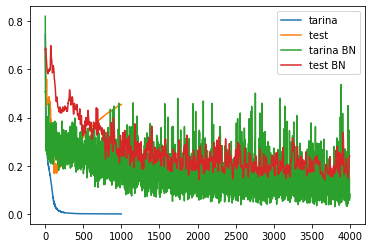

In [16]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

plt.plot(history_Adam_1.history['loss'], label = "tarina BN")
plt.plot(history_Adam_1.history['val_loss'], label = "test BN")

plt.legend()
plt.show()

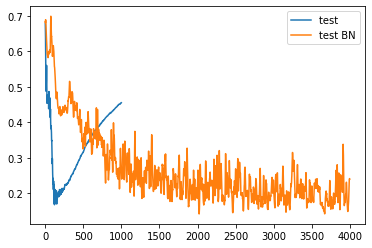

In [17]:
# plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina BN")
plt.plot(history_Adam_1.history['val_loss'], label = "test BN")

plt.legend()
plt.show()

In [19]:
np.min(history_Adam.history['val_loss'])

0.16733430325984955

In [20]:
np.min(history_Adam_1.history['val_loss'])

0.1414727419614792

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


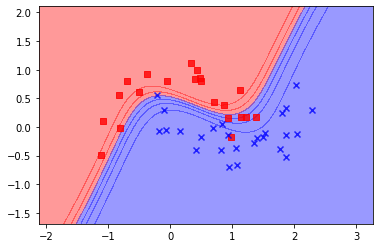

In [12]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()